In [1]:
import pandas as pd
import numpy as np
import json
import scipy.signal
import matplotlib.pyplot as plt

def vel_filter(ang_vel_all):
    b, a = scipy.signal.butter(2, 0.1, 'lowpass')
    return scipy.signal.filtfilt(b, a, ang_vel_all)

# Load data
data = pd.read_csv('GazeDataEval/gaze_data_fake.csv', sep=',')

# Load JSON file for trial details
with open("trials.json", "r") as f:
    trial_details = json.load(f)

# Process segment JSON data
def process_segments(trial_details):
    trial_data = []
    for trial in trial_details:
        trial_id = trial['trial_id']
        initial_ball = trial['initial_ball_placement']
        initial_crosshair = trial['initial_crosshair_placement']
        for i, segment in enumerate(trial['segments']):
            trial_data.append({
                'trial_id': trial_id,
                'segment_id': i + 1,
                'initial_ball_x': initial_ball['x'],
                'initial_ball_y': initial_ball['y'],
                'initial_crosshair_x': initial_crosshair['x'],
                'initial_crosshair_y': initial_crosshair['y'],
                'camera_position_x': segment['camera_position'][0],
                'camera_position_y': segment['camera_position'][1],
                'camera_position_z': segment['camera_position'][2],
                'camera_rotation_x': segment['camera_rotation'][0],
                'camera_rotation_y': segment['camera_rotation'][1],
                'camera_rotation_z': segment['camera_rotation'][2],
                'kick_force_x': segment['kick_force'][0],
                'kick_force_y': segment['kick_force'][1],
                'kick_force_z': segment['kick_force'][2],
                'duration_start': segment['duration'][0],
                'duration_end': segment['duration'][1],
                'contrast_threshold_multiplier': segment.get('contrast_threshold_multiplier', None),
            })
    return pd.DataFrame(trial_data)

segment_df = process_segments(trial_details)

def add_speed_columns(df):
    first_speeds = df[df['segment_id'] == 1][['trial_id', 'kick_force_x']].rename(columns={'kick_force_x': 'first_segment_kick_force'})
    df = df.merge(first_speeds, on='trial_id', how='left')
    return df

segment_df = add_speed_columns(segment_df)

# Map TrialID to segments in CSV data
def map_camera_motion_and_kick_force(data_df, segment_df):
    data_df = data_df.merge(
        segment_df[['trial_id', 'camera_position_x', 'camera_position_y', 'camera_position_z',
                    'camera_rotation_x', 'camera_rotation_y', 'camera_rotation_z',
                    'kick_force_x', 'kick_force_y', 'kick_force_z',
                    'contrast_threshold_multiplier']],
        left_on='TrialID', right_on='trial_id', how='left'
    )
    return data_df

data = map_camera_motion_and_kick_force(data, segment_df)

# Screen parameters
screen_width = 2560
screen_height = 1440
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters

# FILTERING FOR VALID TRIALS 
data = data[data['TrialSection'] == "TRIAL"]
# data = data[data['EndingObjectDirection'] == data['AnswerEndingObjectDirection']]

# Process data
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = screen_height - data['BestPogY'] * screen_height
data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
print(data[['BallX', 'BallY']])
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

# Apply filter to each trial
def apply_filter_per_trial(df, column_name, new_column_name):
    df[new_column_name] = df.groupby('TrialNumber')[column_name].transform(lambda x: vel_filter(x.fillna(0)))
    return df

data = apply_filter_per_trial(data, 'MappedPogX', 'FilteredPogX')
data = apply_filter_per_trial(data, 'MappedPogY', 'FilteredPogY')

# Compute angular error
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = diagonal_resolution / screen_diagonal_size  # Pixels per inch
    distance_to_screen_pixels = distance_to_screen * pixel_size * 39.37  # Convert meters to inches

    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    df['PixelDistance'] = np.sqrt((df['FilteredPogX'] - df['BallX'])**2 + (df['FilteredPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

# Discard trials with high angular error
def discard_trials_with_high_angular_error(df, angular_error_threshold):
    trials_to_discard = df[df['AngularError'] > angular_error_threshold]['TrialNumber'].unique()
    return df[~df['TrialNumber'].isin(trials_to_discard)]

# angular_error_threshold = 30.0
# data = discard_trials_with_high_angular_error(data, angular_error_threshold)

# print(data)


           BallX     BallY
60   1368.274000  503.8842
61   1356.151000  501.3510
62   1343.713000  496.6551
63   1330.947000  489.7111
64   1330.947000  489.7111
..           ...       ...
380    27.234130  334.6212
381    20.190070  333.9885
382    13.122940  333.3536
383    13.122940  333.3536
384     6.032181  332.7166

[325 rows x 2 columns]


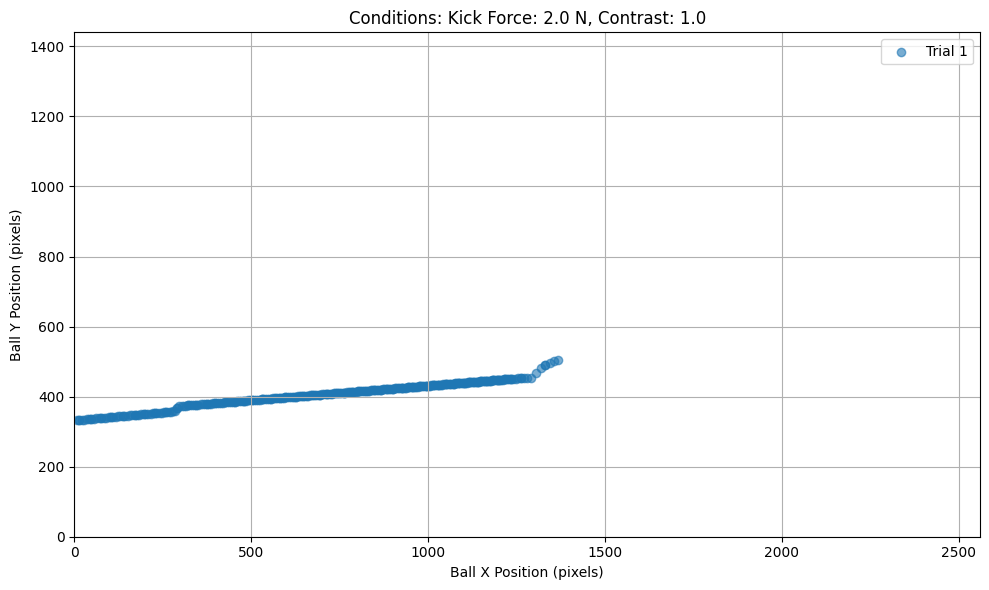

C:\Users\Jenna\AppData\Local\Temp\ipykernel_33920\721049103.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


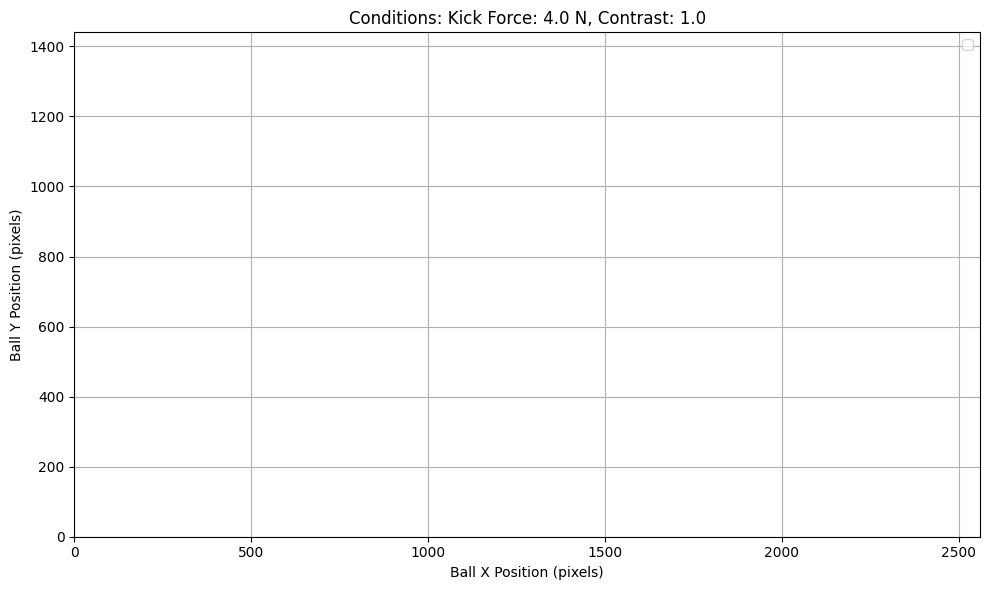

In [3]:
def plot_combined_trials(data, trial_details_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6):
    import matplotlib.pyplot as plt

    # Group trials by unique conditions including contrast and kick force
    grouping_columns = ['kick_force_x', contrast_threshold_column]
    grouped_trials = trial_details_df.groupby(grouping_columns)

    for group_key, group in grouped_trials:
        # Extract conditions for title
        kick_force, contrast_threshold = group_key
        unique_trial_ids = group['trial_id'].unique()

        if len(unique_trial_ids) == 0:
            continue

        # Create a new plot for this group
        plt.figure(figsize=(10, 6))

        for trial_id in unique_trial_ids:
            # Filter data for the current trial ID
            trial_data = data[data['TrialID'] == trial_id]

            if trial_data.empty:
                continue

            # Plot BallX and BallY positions on an XY axis
            plt.scatter(
                trial_data['BallX'],
                trial_data['BallY'],
                label=f'Trial {trial_id}',
                alpha=alpha
            )

        # Set plot titles and labels
        title_parts = [
            f"Kick Force: {kick_force} N",
            f"Contrast: {contrast_threshold}"
        ]
        plt.title("Conditions: " + ", ".join(title_parts))
        plt.xlabel("Ball X Position (pixels)")
        plt.ylabel("Ball Y Position (pixels)")
        plt.xlim(0, 2560)  # Assuming screen width
        plt.ylim(0, 1440)  # Assuming screen height
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"niall_plots_1/kick_force_{kick_force}_contrast_{contrast_threshold}.png")
        # Display the plot
        plt.show()

# Example usage
angular_threshold = 1.2  # Degrees
time_passed_seconds = 0.25
contrast_threshold_column = 'contrast_threshold_multiplier'

plot_combined_trials(data, segment_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6)


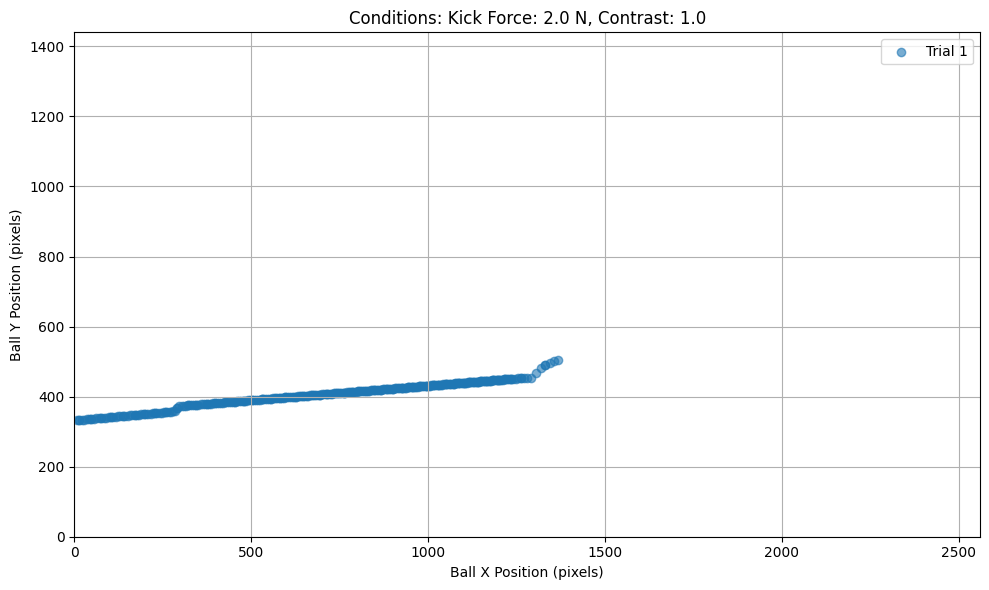

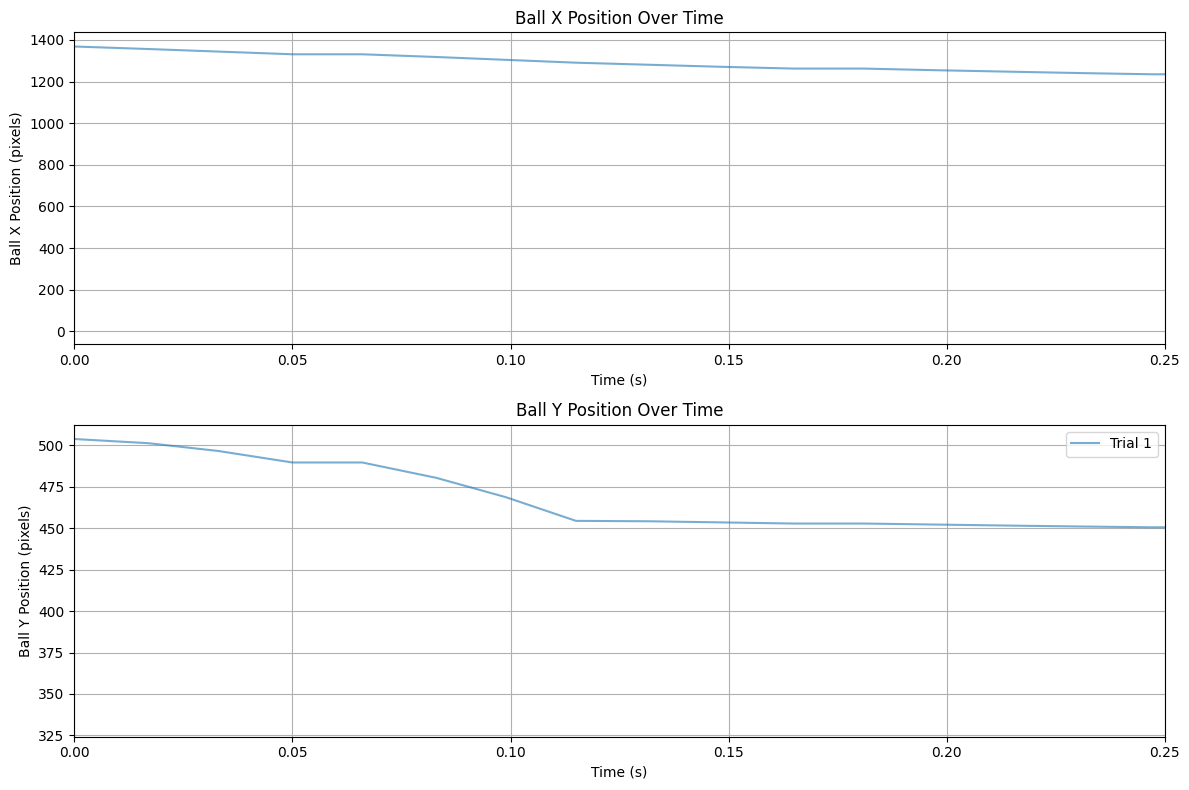

C:\Users\Jenna\AppData\Local\Temp\ipykernel_33920\2324017316.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


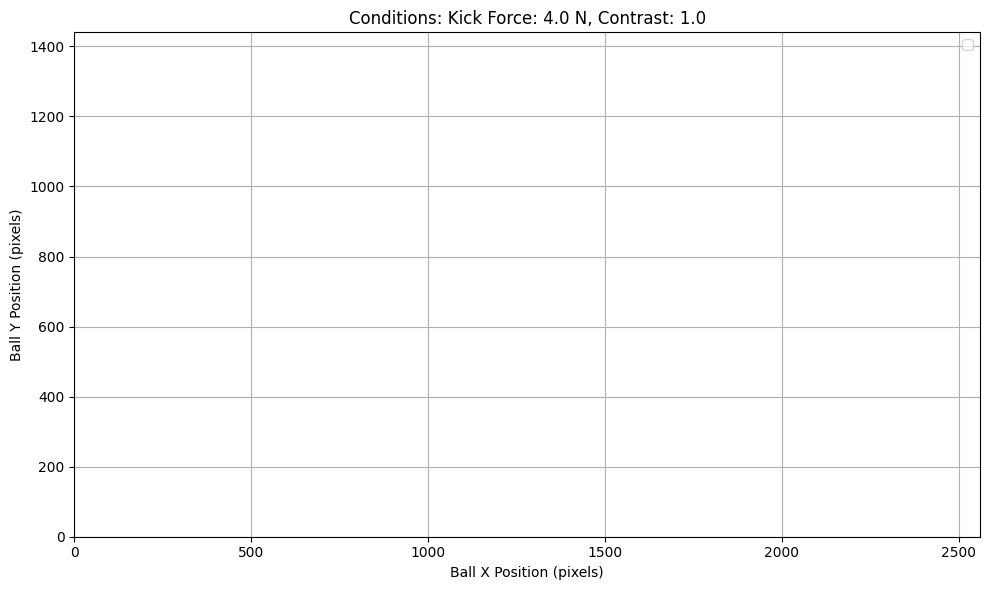

C:\Users\Jenna\AppData\Local\Temp\ipykernel_33920\2324017316.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


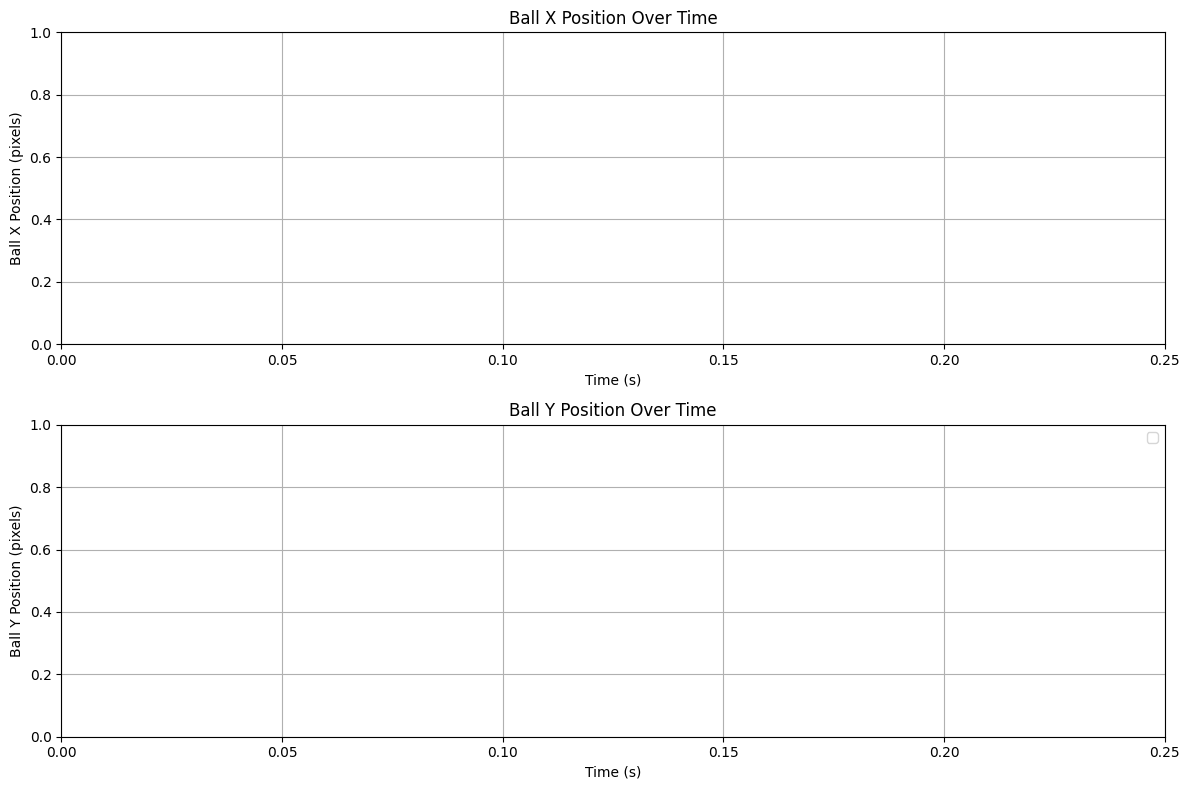

In [4]:
def plot_combined_trials(data, trial_details_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6):
    import matplotlib.pyplot as plt

    # Group trials by unique conditions including contrast and kick force
    grouping_columns = ['kick_force_x', contrast_threshold_column]
    grouped_trials = trial_details_df.groupby(grouping_columns)

    for group_key, group in grouped_trials:
        # Extract conditions for title
        kick_force, contrast_threshold = group_key
        unique_trial_ids = group['trial_id'].unique()

        if len(unique_trial_ids) == 0:
            continue

        # Create scatter plot for BallX and BallY positions
        plt.figure(figsize=(10, 6))
        for trial_id in unique_trial_ids:
            trial_data = data[data['TrialID'] == trial_id]
            if trial_data.empty:
                continue

            plt.scatter(
                trial_data['BallX'],
                trial_data['BallY'],
                label=f'Trial {trial_id}',
                alpha=alpha
            )

        title_parts = [
            f"Kick Force: {kick_force} N",
            f"Contrast: {contrast_threshold}"
        ]
        plt.title("Conditions: " + ", ".join(title_parts))
        plt.xlabel("Ball X Position (pixels)")
        plt.ylabel("Ball Y Position (pixels)")
        plt.xlim(0, 2560)
        plt.ylim(0, 1440)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"niall_plots_1/kick_force_{kick_force}_contrast_{contrast_threshold}_scatter.png")
        plt.show()

        # Create separate plots for X and Y positions over time
        plt.figure(figsize=(12, 8))

        # Plot BallX over time
        plt.subplot(2, 1, 1)
        for trial_id in unique_trial_ids:
            trial_data = data[data['TrialID'] == trial_id]
            if trial_data.empty:
                continue

            plt.plot(
                trial_data['RelativeTime'],
                trial_data['BallX'],
                label=f'Trial {trial_id}',
                alpha=alpha
            )
        plt.title("Ball X Position Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Ball X Position (pixels)")
        plt.xlim(0, time_passed_seconds)
        plt.grid(True)

        # Plot BallY over time
        plt.subplot(2, 1, 2)
        for trial_id in unique_trial_ids:
            trial_data = data[data['TrialID'] == trial_id]
            if trial_data.empty:
                continue

            plt.plot(
                trial_data['RelativeTime'],
                trial_data['BallY'],
                label=f'Trial {trial_id}',
                alpha=alpha
            )
        plt.title("Ball Y Position Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Ball Y Position (pixels)")
        plt.xlim(0, time_passed_seconds)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.savefig(f"niall_plots_1/kick_force_{kick_force}_contrast_{contrast_threshold}_time_series.png")
        plt.show()

# Example usage
angular_threshold = 1.2  # Degrees
time_passed_seconds = 0.25
contrast_threshold_column = 'contrast_threshold_multiplier'

plot_combined_trials(data, segment_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6)
